# 1. Goals

Analyse data and develop prediction models for the concentration of CO2 on the atmosphere and the global temperature from 1850 onwards.

In this respect, the following tasks are performed:
1. Statistics: Analyse relevant statistics, such as autocorrelation, stationarity, trend, seasonality and noise
2. Correlation vs Causation: analyse and discuss the relationship between CO2 concentration and global temperature
3. Prediction: develop and evaluate a prediction model;
4. Prediction with support Series: develop a prediction model for Global Temperature using CO2 concentration as a support series

# 2. Imports and Utility functions

In [361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import yeojohnson
import statsmodels.api as sm
import itertools
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings("ignore")

In [600]:
def plot_timeseries(timeseries, figsize=(8,6)):
    """Utility function to plot timeseries data controlling figsize"""
    
    plt.figure(figsize=figsize)
    timeseries.plot()
    plt.title(timeseries.name)
    plt.xticks(rotation='vertical')
    plt.show()
    
    return None

In [599]:
def test_adfuller(timeseries):
    """Perform Dickey-Fuller test on `timeseries` and display results"""
    
    print('Results of Dickey-Fuller Test:')
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_out = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','# of Lags', '# of Observations'])
    for key, value in adf_test[4].items():
        adf_out[f'Critical Value {key}'] = value
    print(adf_out)
    
    return None

In [601]:
def plot_rolling_mean(timeseries, window=12, figsize=(8,6)):
    """Utility function to determine rolling mean and plot data"""
    
    #Determing rolling statistics
    roll_mean = timeseries.rolling(window=window).mean()

    #Plot rolling statistics:
    plt.figure(figsize=figsize)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title(f'{timeseries.name} \nRolling Mean')
    
    return None

In [609]:
def plot_rolling_mean_std(timeseries, window=12, figsize=(8,6)):
    """Displays a plot of the original `timeseries` alongside a rolling
    mean and rolling standard deviation for visual inspection.
    
    Original source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/"""
    
    #Determing rolling statistics
    roll_mean = timeseries.rolling(window=window).mean()
    roll_std = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    plt.figure(figsize=figsize)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'{timeseries.name} \nRolling Mean & Rolling Standard Deviation')
    
    return None

In [603]:
def plot_boxcox_yeojonson_transf(timeseries):
    """Utility function to visualize distributions of 
    original data, Box-Cox transformed and Yeo-Johnson 
    transformed versions"""
    
    # compute Box-Cox transform
    bc_timeseries_values, bc_lambda = boxcox(timeseries)
    bc_timeseries = pd.Series(
        data=bc_timeseries_values,
        index=timeseries.index)

    # compute YeoJohnson transform
    yj_timeseries_values, yj_lambda = yeojohnson(timeseries)
    yj_timeseries = pd.Series(
        data=yj_timeseries_values,
        index=timeseries.index)

    # plot original and both transforms
    f, axes = plt.subplots(ncols=3, figsize=(18, 6))
    timeseries.hist(ax=axes[0])
    bc_timeseries.hist(ax=axes[1])
    yj_timeseries.hist(ax=axes[2])

    # set titles
    axes[0].set_title(f"{timeseries.name}")
    axes[1].set_title(f"Box-cox Transformed \n{timeseries.name}")
    axes[2].set_title(f"Yeo-Johnson Transformed \n{timeseries.name}")

    plt.show()
    
    return None

In [6]:
def plot_yearly_boxplot(timeseries, figsize=(8,6)):
    """Plot a boxplot of the `timeseries` grouped by year."""

    plt.figure(figsize=figsize)
    sns.boxplot(timeseries.index.year, timeseries)
    plt.xticks(rotation='vertical')
    plt.title(f'Boxplot - Yearly - {timeseries.name}')
    plt.show()
    
    return None

In [53]:
def plot_bin_stats(timeseries, stats_ls=['mean', 'std'], n_bins=15, figsize=(12,6)):
    """Displays mean and standard deviation by user-defined number of bins.
    Splits using index."""
    
    data_col = timeseries.name
    data_df = pd.DataFrame(timeseries)
    data_df['bins'] = pd.cut(timeseries.index.values, bins=n_bins)
    data_df.groupby('bins')[data_col].agg(stats_ls).plot(figsize=figsize)
    plt.xticks(rotation='vertical')
    plt.title(timeseries.name)
    plt.show()
    
    return None

In [8]:
def extract_seasonal_decomp_features(timeseries, freq, model='additive'):
    """Applies a seasonal decomposition to `timeseries` and returns each
    feature"""
    
    # decompse the timeseries and extract each series
    decomposition = seasonal_decompose(timeseries, freq=freq, model=model)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    return trend, seasonal, residual

In [9]:
def plot_decomposition(timeseries, trend, seasonal, residual):
    """Display each element of a seasonal decomposition of a timeseries
    in a separate plot."""

    plt.figure(figsize=(16,12))
    plt.subplot(411)
    plt.plot(timeseries)
    plt.title('Original')
    plt.subplot(412)
    plt.plot(trend)
    plt.title('Trend')
    plt.subplot(413)
    plt.plot(seasonal)
    plt.title('Seasonality')
    plt.subplot(414)
    plt.plot(residual)
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()
    
    return None

In [604]:
def plot_acf_pacf(timeseries, nlags=5):
    """Utility function to dispaly AutoCorrelation Function and
    Partial AutoCorrelation Function plots
    
    Original source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/"""
    
    lag_acf = tsa.acf(timeseries, nlags=nlags)
    lag_pacf = tsa.pacf(timeseries, nlags=nlags, method='ols')
    
    # adjust plot settings and plot
    plt.figure(figsize=(16,8))
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    
    plt.tight_layout()
    plt.show()
    
    return None

In [605]:
def mean_absolute_percentage_error(y_true, y_predicted):
    """Utility function to compute Mean Absolutte Percentage Error"""

    return np.mean(np.abs((y_true - y_predicted) / y_true)) * 100

In [598]:
def plot_predictions(y_train, y_test, y_predicted, title, figsize=(12,8)):
    """Utility function to plot predicted values alongside
    train and test sets"""
    
    plt.figure(figsize=figsize)
    plt.plot(y_train, label='Train')
    plt.plot(y_test, label='Test')
    plt.plot(y_predicted, label=title)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

    return None

In [608]:
def find_sarima_param(y_train, seasonal_period=12):
    """Function iterate over combinarions of ARIMA (p,d,q) order
    and seasonal order (p,d,q,m) and find best combination using
    Akaike Information Criterion.
    
    Original source: https://github.com/gianfelton/SARIMA-Param-Search-for-Python/blob/master/Seasonal%20ARIMA%20with%20Param%20Search.ipynb"""
    
    p = d = q = range(0, 2)
    pdq = itertools.product(p, d, q)
    seasonal_pdq = ((x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q)))

    results_ls = []
    results_dict = {}
    for pdq_order in pdq:
        for seasonal_pdq_order in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(y_train,
                                                  order=pdq_order,
                                                  seasonal_order=seasonal_pdq_order)

                results = model.fit()
                results_dict = {'aic':results.aic, 'order':pdq_order,
                                'seasonal_order':seasonal_pdq_order}
                results_ls.append(results_dict)
            except:
                pass

        results_df = pd.DataFrame(results_ls)
    
    lowest_aic_idx = results_df['aic'].idxmin()

    summary = {'aic': results_df.iloc[lowest_aic_idx, 0],
               'order': results_df.iloc[lowest_aic_idx, 1], 
               'seasonal_order': results_df.iloc[lowest_aic_idx, 2]}
    
    return summary

In [606]:
def print_diagnostics(true_values, predicted_values, print_message):
    """Utility function to print RMSE, MAPE and and plots the residuals"""
    
    print(f'{print_message}')
    print(f'RMSE: {np.sqrt(mean_squared_error(true_values, predicted_values))}')
    print(f'MAPE: {mean_absolute_percentage_error(true_values, predicted_values)}')
    
    residuals = true_values - predicted_values
    residuals.hist()
    plt.title('Residuals')
    plot_acf(residuals)
    
    plt.show()
    return None

# 3. Load Data

CO2 data is sourced from the [ETH Zurich's Institute for Atmospheric and Climate Science](https://iac.ethz.ch/). Global Temperature Data is available as a [Kaggle Dataset](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data/data#GlobalTemperatures.csv), but it downloaded here from my personal GitHub account where it was made available to avoid using the Kaggle API.

In [607]:
# load data
CO2_URL = 'ftp://data.iac.ethz.ch/CMIP6/input4MIPs/UoM/GHGConc/CMIP/mon/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701/mole_fraction_of_carbon_dioxide_in_air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-1-0_gr3-GMNHSH_000001-201412.csv'
TEMPERATURE_PATH = 'https://raw.githubusercontent.com/alvarocapelo/time-series-analysis/master/data/temperature.csv'

co2_rawdata = pd.read_csv(CO2_URL, header=0, index_col=4, parse_dates=True)
temp_rawdata = pd.read_csv(TEMPERATURE_PATH, header=0, index_col=0, parse_dates=True)

# 4. Task \#1: Time Series Analysis

As the name states, Time Series analysis (and modelling) involves analysing and modelling the effect of the time in a particular process.

When attempting to model such processes, most of the classical tools make strong assumptions about the behavior of the data. Arguably the strongest one is that of a stationary process. This definition can be found accross the web, but one very succint explanation can be found on an [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) blog post:

"
*Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:*
    
- *constant mean*
- *constant variance*
- *an autocovariance that does not depend on time.*
"

Usually, Stationarity testing and converting a time series into a stationary series are the most critical processes in a time series modelling, as most models rely on this structure. This we be the main task of this report in order to developed the prediction models.

**Analysing Stationarity, Trend, Seasonality and Noise**

Inspecting stationarity can be done both visually and statistically.

The visual aspect will make use of some Python libraries and plots. Some utility functions are defined within this Notebook, and others available through imports.

The statistical part in this report is performed through the Augmented Dick-Fuller test. It tests for a null-hypothesis that Time Series is non-stationarity, i.e., that it has some time-dependent structure.

This is done through a Test Statistic and associated p-value:
- if p-value < confidence level (usually 5%) => null hypothesis should be rejected, and the series should be considered non-stationary
- if p-value > confidence level (usually 5%) => fail to reject the null hypothesis, and the series should be considered stationary

## 4.1. Global Temperature Data

First, a few exploratory actions and plots.

In [12]:
temp_rawdata.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
temp_rawdata.describe()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
count,3180.000000,3180.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000
mean,8.374731,0.938468,14.350601,0.479782,2.743595,0.431849,15.212566,0.128532
std,4.381310,1.096440,4.309579,0.583203,4.155835,0.445838,1.274093,0.073587
min,-2.080000,0.034000,5.900000,0.044000,-5.407000,0.045000,12.475000,0.042000
25%,4.312000,0.186750,10.212000,0.142000,-1.334500,0.155000,14.047000,0.063000
50%,8.610500,0.392000,14.760000,0.252000,2.949500,0.279000,15.251000,0.122000
75%,12.548250,1.419250,18.451500,0.539000,6.778750,0.458250,16.396250,0.151000
max,19.021000,7.880000,21.320000,4.373000,9.715000,3.498000,17.611000,0.457000


In [14]:
temp_rawdata.isna().sum()

LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

Overall there's a lot of data available. Since we're lookign at a global temperature perspective, it seems both appropriate and more simple to select the **Land and Ocean Average Temperature** time series for this analysis.

Also, the we'll be evaluating data

**Exploratory Data Analysis**

In [15]:
landocean_temp = temp_rawdata['1850':]['LandAndOceanAverageTemperature']

In [16]:
landocean_temp.describe()

count    1992.000000
mean       15.212566
std         1.274093
min        12.475000
25%        14.047000
50%        15.251000
75%        16.396250
max        17.611000
Name: LandAndOceanAverageTemperature, dtype: float64

In [17]:
landocean_temp.isna().sum()

0

At this point, the datatype seems fine, no absurd values are present and there's no need for inputations, since no Null value is present.

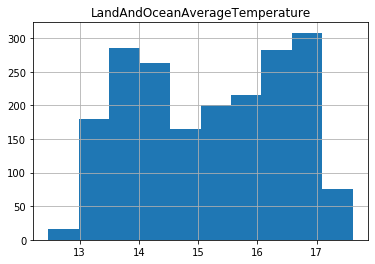

In [18]:
# looking at the distribution of the data
landocean_temp.hist()
plt.title(landocean_temp.name)
plt.show()

The histogram suggests that the data is Gaussian-like, but not exactly normal. Since most tests assume a Gaussian-like distribution, it's worth looking into transformations such as Box-Cox or Yeo-Johnson.

These transformations also help stabilizing the non-constant variance of a series, which may be helpful.

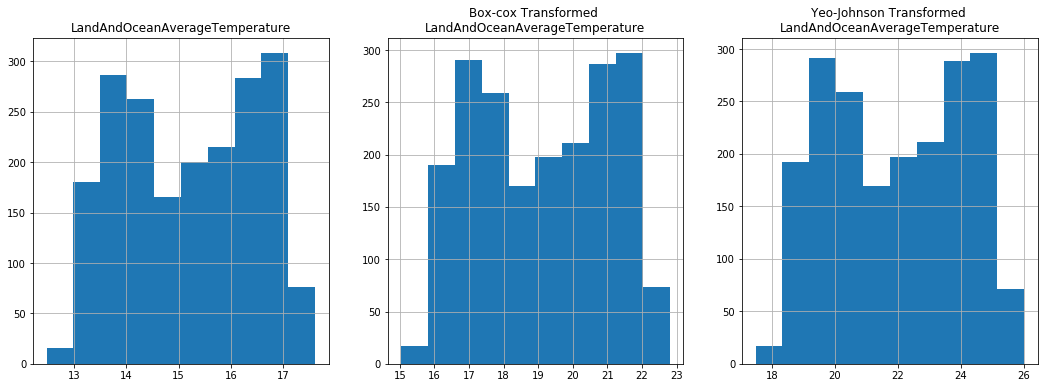

In [19]:
plot_boxcox_yeojonson_transf(landocean_temp)

For simplicity, since in this case they yield very similar distributions, no transformation will be applied.

**Visual Stationarity inspection**

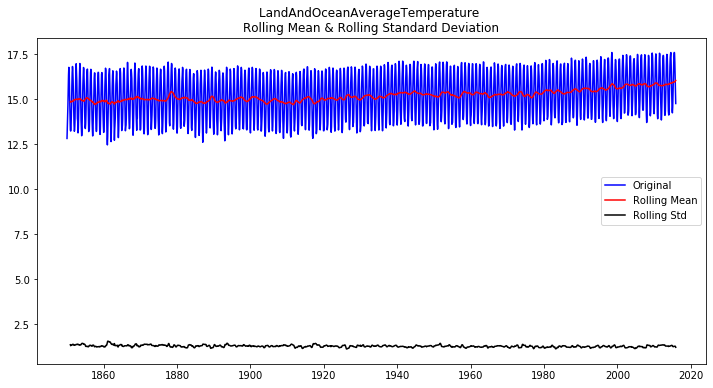

In [20]:
plot_rolling_mean_std(landocean_temp, window=12, figsize=(12,6))

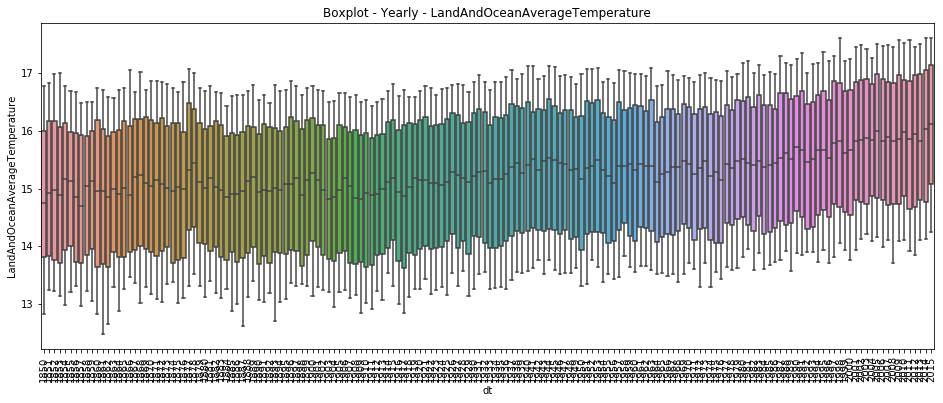

In [21]:
plot_yearly_boxplot(landocean_temp, figsize=(16,6))

On a smaller number of "groups" (or bins).

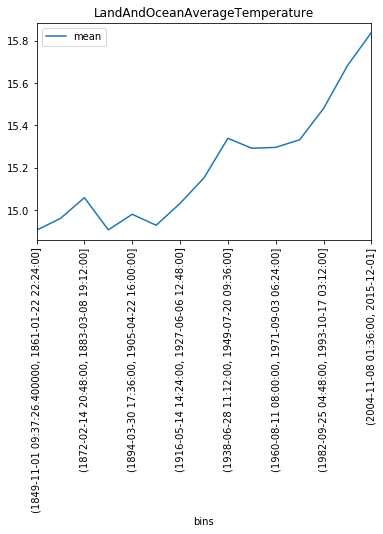

In [133]:
plot_bin_stats(landocean_temp, stats_ls=['mean'], figsize=(6,4))

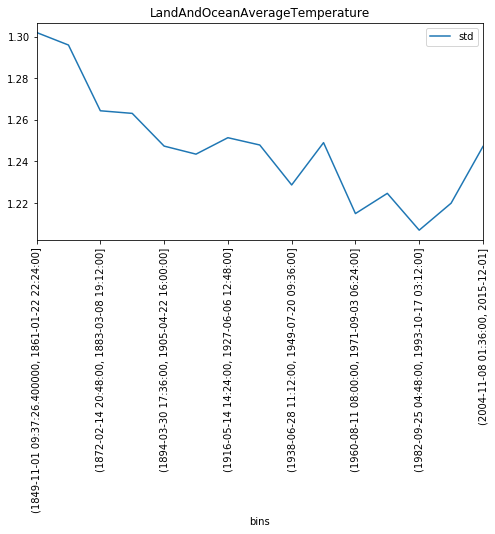

In [136]:
plot_bin_stats(landocean_temp, stats_ls=['std'], figsize=(8,4))

After the brief inspection above, the data appear to display an upwards trend. Additionally, at this point it's visible that the variance is not constant. Both suggest a non-stationary time series.

Going a little further:

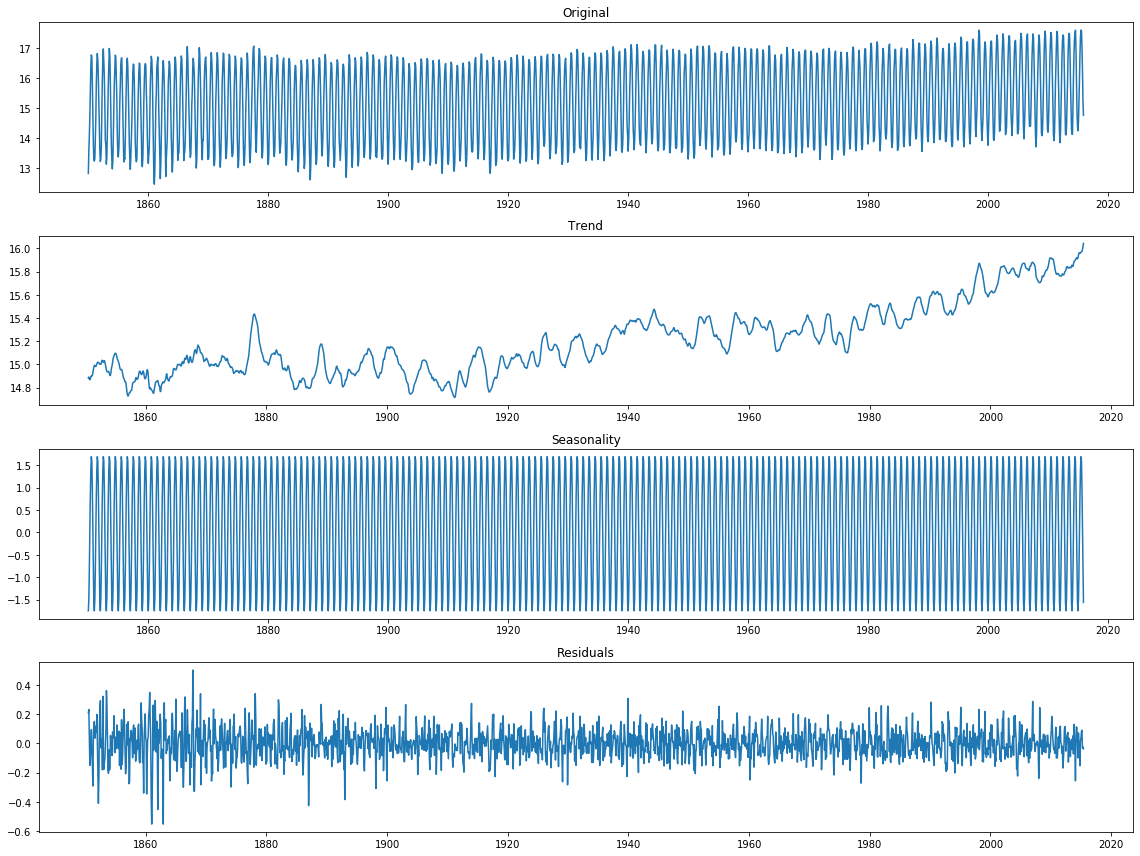

In [363]:
trend, seasonal, residual = extract_seasonal_decomp_features(
    landocean_temp, freq=12, model='additive')
plot_decomposition(landocean_temp, trend, seasonal, residual)

Inspecting the Autocorrelation of the time series:

/home/alvaroac/miniconda3/envs/ds/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


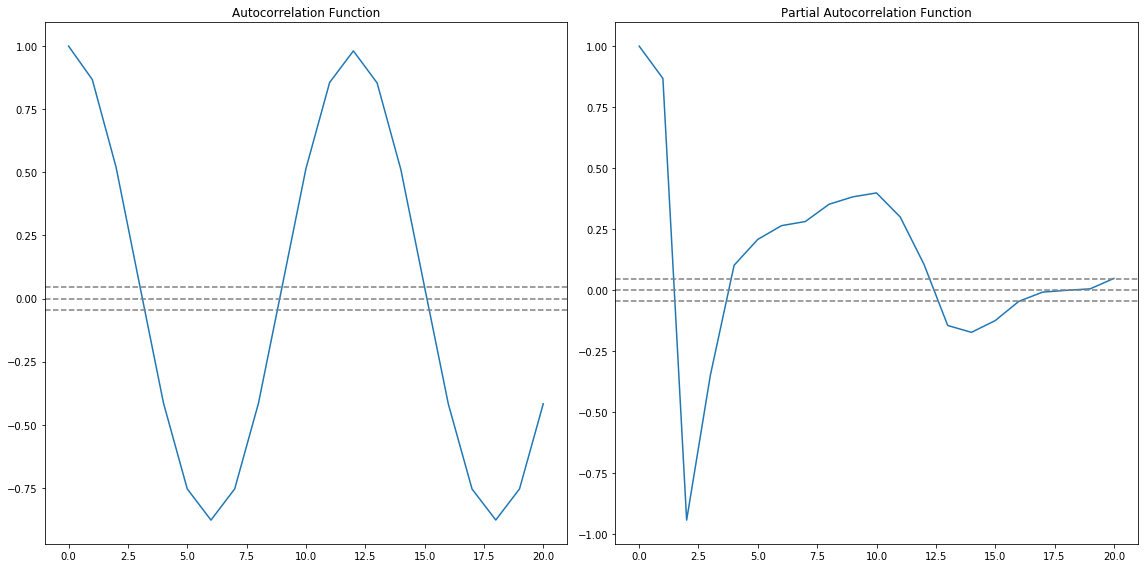

In [27]:
plot_acf_pacf(landocean_temp, nlags=20)

Two main aspects of the AutoCorrelation Function plot above:
1. it descreases rapidly as the number of lags increase
2. it has cossine-like pattern

In agreement with previous plots, the quick decay in the ACF suggests a small trend, whereas the cyclical behavior suggests a strong seasonality component. The former is to be expected, as with the seasons of the year, temperature displays a related pattern.

Inspecting the residuals more closesly:

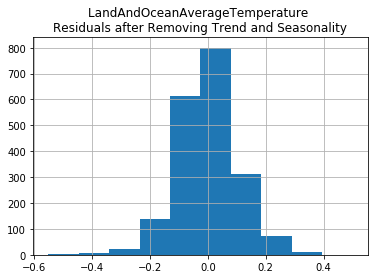

In [364]:
residual.hist()
plt.title(f'{landocean_temp.name} \nResiduals after Removing Trend and Seasonality')
plt.show()

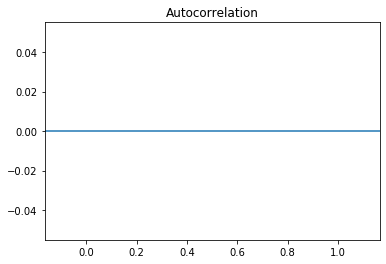

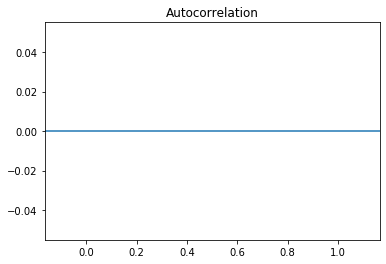

In [29]:
plot_acf(residual)

Tha above plots suggest that after removing trend and seasonality, the residuals:
- have zero mean over time
- appear to have a constant variance over time
- seem normally distributed (Gaussian-like at least)
- do not present autocorrelation

Going formal and actually testing for Statationarity, the Augmented Dick-Fuller test is applied.

In [26]:
test_adfuller(landocean_temp)

Results of Dickey-Fuller Test:
Test Statistic          -1.135299
p-value                  0.700792
# of Lags               26.000000
# of Observations     1965.000000
Critical Value 1%       -3.433682
Critical Value 5%       -2.863012
Critical Value 10%      -2.567554
dtype: float64


Both the visual inspection and Dick-Fuller's statistical test suggest a non-stationary time series. Additionally, as suggested on previous plots, the timeseries seems to be composed of:
- an upwards trend
- a strong seasonal component
- a seemingly normally distributed error term

This information will be useful when deciding which univariate model is adequate.

## 4.2. CO2 Data

In [487]:
co2_rawdata.head()

,datenum,year,month,day,data_mean_global,data_mean_nh,data_mean_sh
datetime,,,,,,,
15-Jan-0000 00:00:00,15,0,1,15,278.366439,279.045659,277.687219
15-Feb-0000 00:00:00,46,0,2,15,278.713058,279.665398,277.760718
15-Mar-0000 00:00:00,75,0,3,15,279.013835,280.266779,277.760892
15-Apr-0000 00:00:00,106,0,4,15,279.209613,280.756607,277.662620
15-May-0000 00:00:00,136,0,5,15,279.106444,280.613494,277.599394


In [488]:
co2_treated = co2_rawdata.where(co2_rawdata.year >= 1850).dropna()
co2 = co2_treated.data_mean_global.rename('GlobalCO2')
co2  = co2.reindex(pd.to_datetime(co2.index))

In [489]:
co2.isna().sum()

0

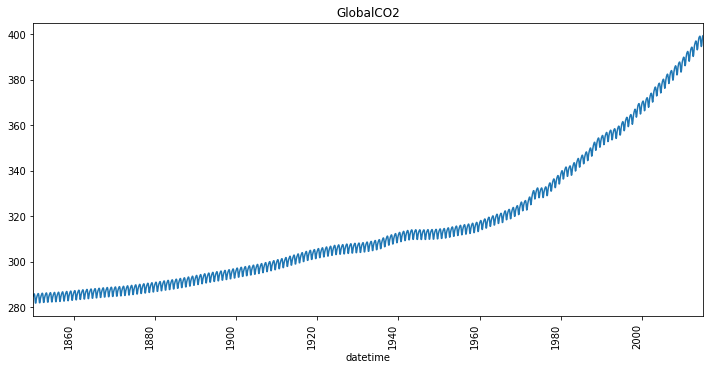

In [490]:
plot_timeseries(co2, figsize=(12,6))

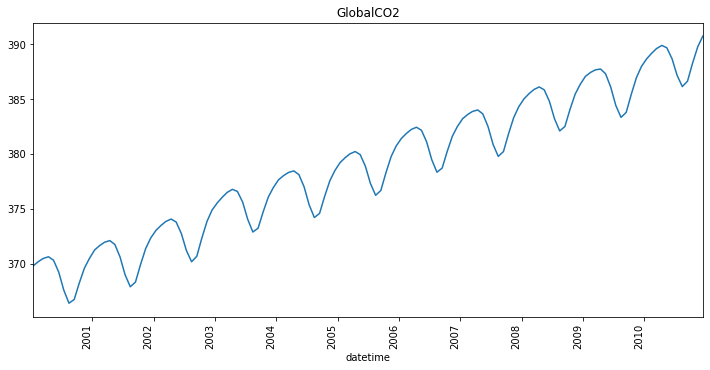

In [491]:
plot_timeseries(co2['2000':'2010'], figsize=(12,6))

The series appears to display an upwards trend and to have a seasonality component of 12 periods. 

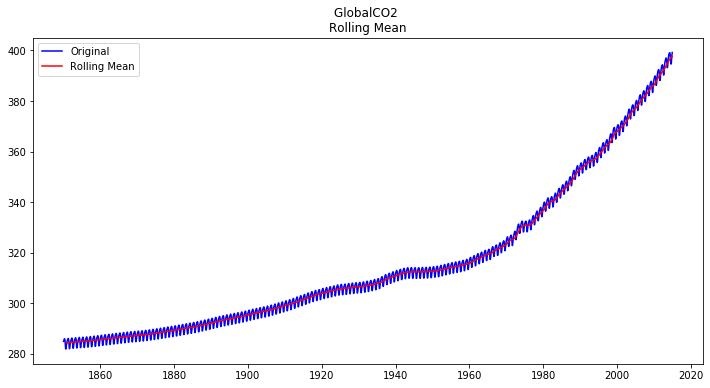

In [494]:
plot_rolling_mean(co2, window=12, figsize=(12,6));

Taking a closer look on a smaller number of "groups" (or bins) and with mean and standard deviation separately.

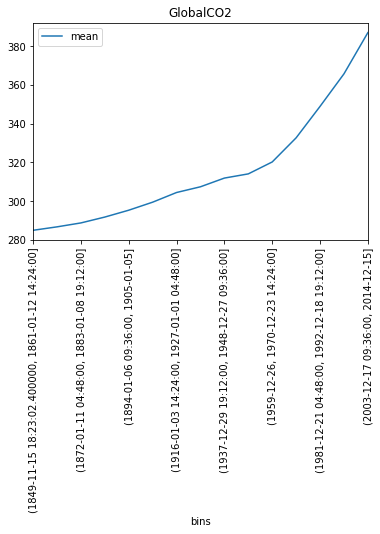

In [495]:
plot_bin_stats(co2, stats_ls=['mean'], figsize=(6,4))

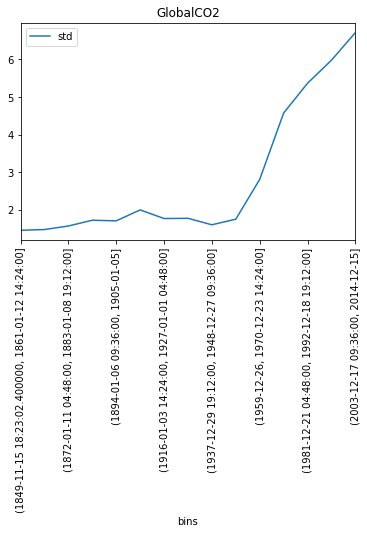

In [496]:
plot_bin_stats(co2, stats_ls=['std'], figsize=(6,4))

Looking at the distribution of the data

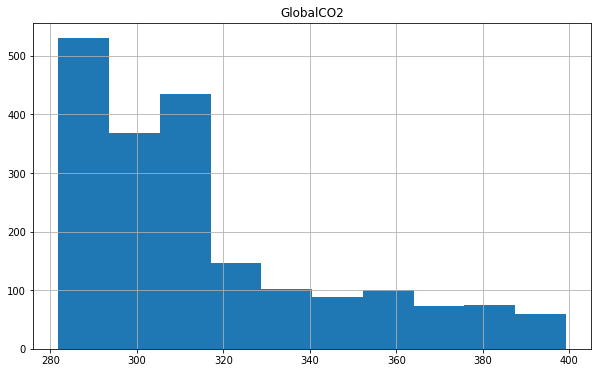

In [492]:
co2.hist(figsize=(10,6))
plt.title(co2.name)
plt.show()

The shape of the distribution suggest that maybe a log transform is adequate. Square-root will also be attempted as it is a common transformation.

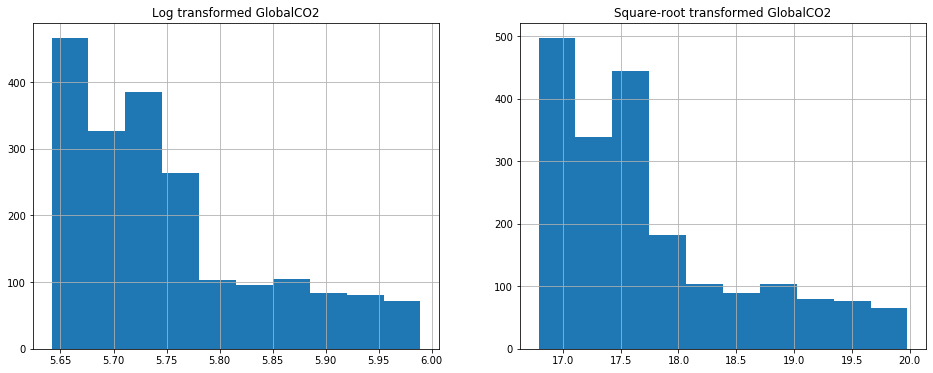

In [493]:
f, axes = plt.subplots(ncols=2, figsize=(16,6))
np.log(co2).hist(ax=axes[0])
np.sqrt(co2).hist(ax=axes[1])

axes[0].set_title(f'Log transformed {co2.name}')
axes[1].set_title(f'Square-root transformed {co2.name}')
plt.show()

None of the above attempted transformations seemed to have much effect on the distribution of the data. However, since the standard deviation changes from the beginning to the end of the series, the log-trasnform will be used to stabilize the variance.

In [498]:
log_co2 = np.log(co2).dropna()

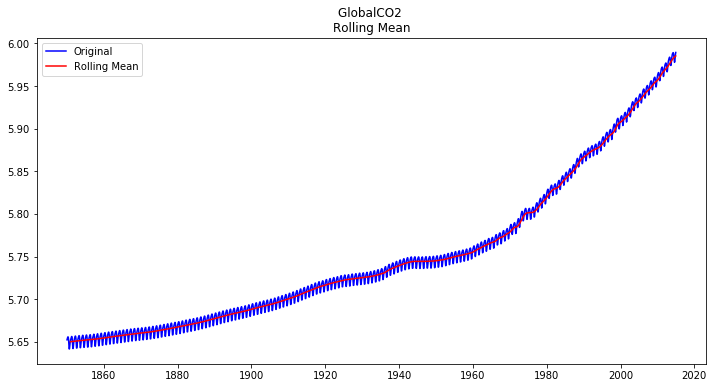

In [499]:
plot_rolling_mean(log_co2, window=12, figsize=(12,6));

Taking a closer look on a smaller number of "groups" (or bins) and with mean and standard deviation separately.

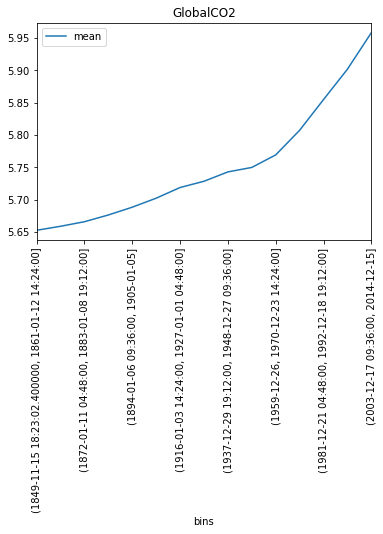

In [500]:
plot_bin_stats(log_co2, stats_ls=['mean'], figsize=(6,4))

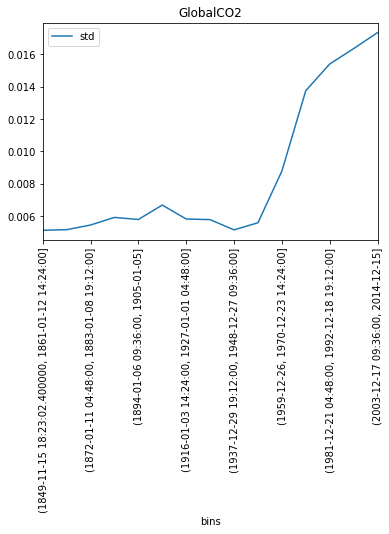

In [501]:
plot_bin_stats(log_co2, stats_ls=['std'], figsize=(6,4))

After quick inspection, CO2 data violates at least the two characteristics of stationarity:
- it doesn't have constant mean, as there'sa clear upwards trend
- it doesn't have constant variance, as the standard deviation explodes at the end of the time series

Moving on, we perform a naive decomposition, as with the Land and Ocean Average Temperature. As with Temperature data, there seems to be a strong seasonal component with period of 12. Hence, this value is used as frequency.

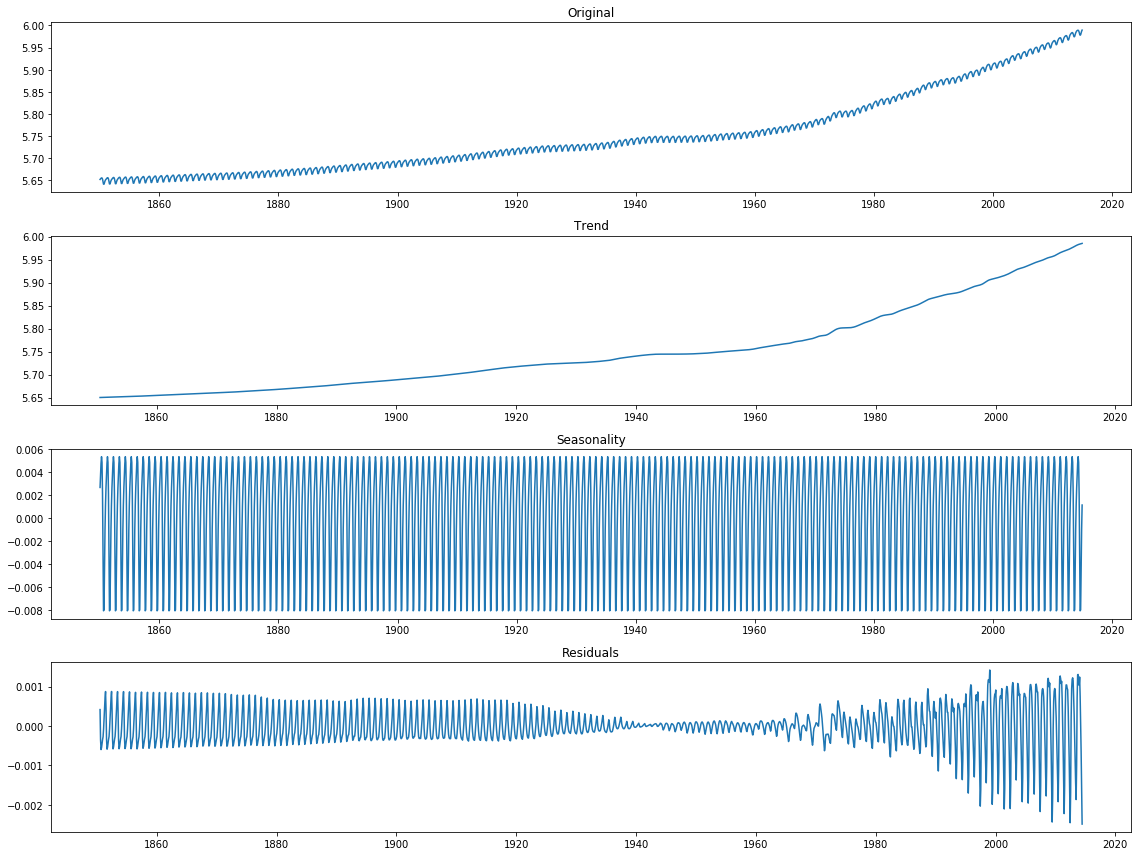

In [510]:
timeseries = log_co2
trend, seasonal, residual = extract_seasonal_decomp_features(
    timeseries, freq=12, model='additive')
plot_decomposition(timeseries, trend, seasonal, residual)

And looking at the ACF/PACF plot:

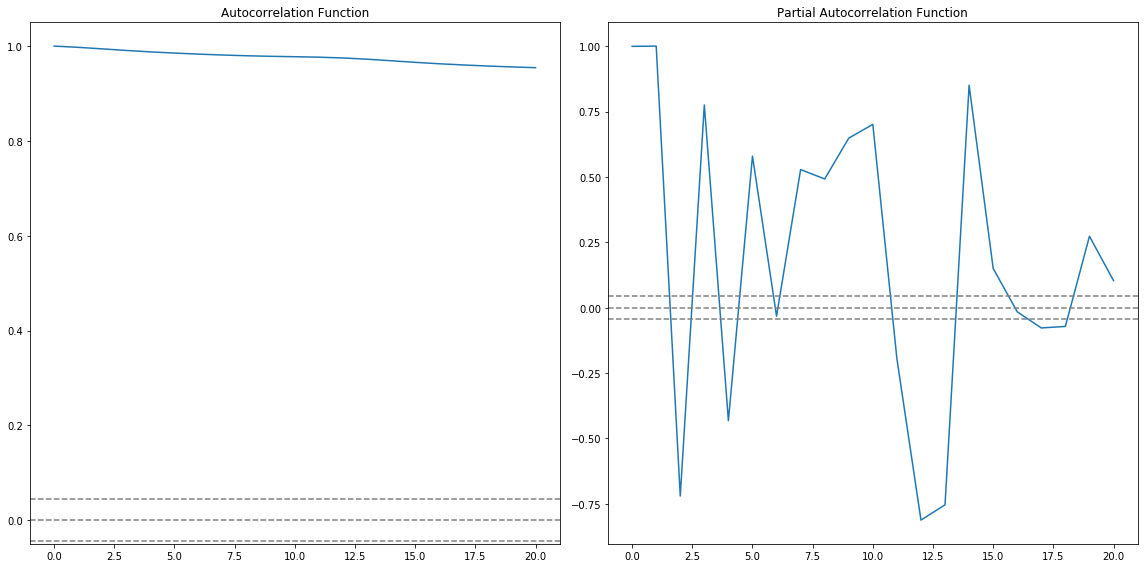

In [511]:
plot_acf_pacf(log_co2, nlags=20)

And observing the residuals:

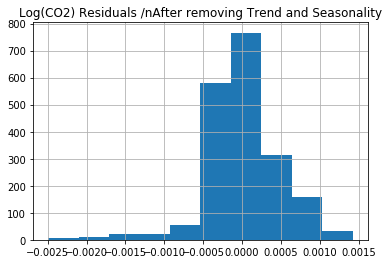

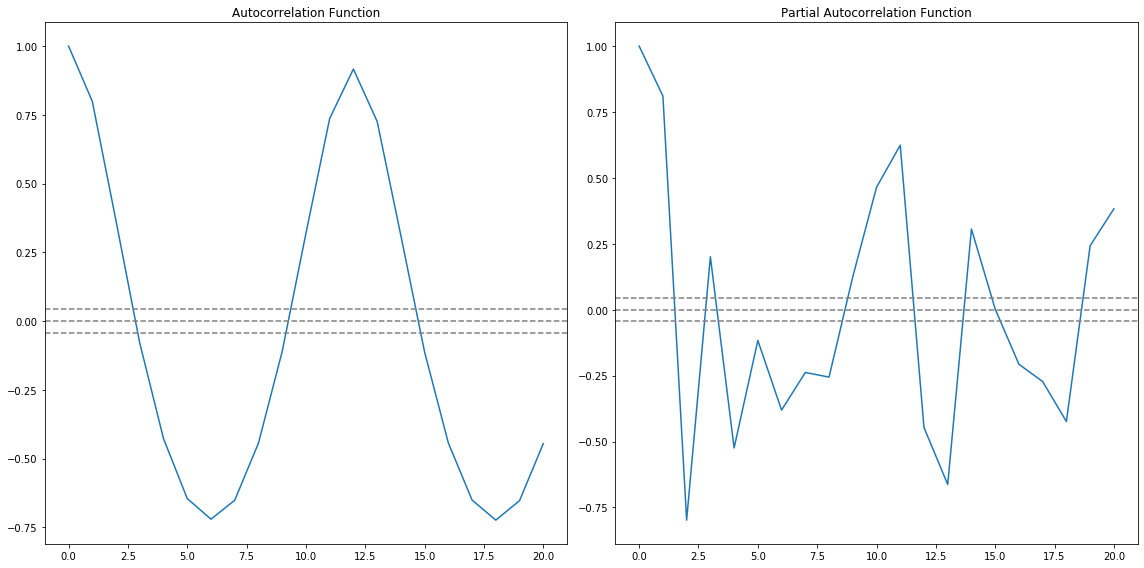

In [515]:
residual.dropna().hist()
plt.title('Log(CO2) Residuals /nAfter removing Trend and Seasonality')
plot_acf_pacf(residual.dropna(), nlags=20)
plt.show()

As there's a seasonality of period 12, it's worth looking into the seasonal difference series as well:

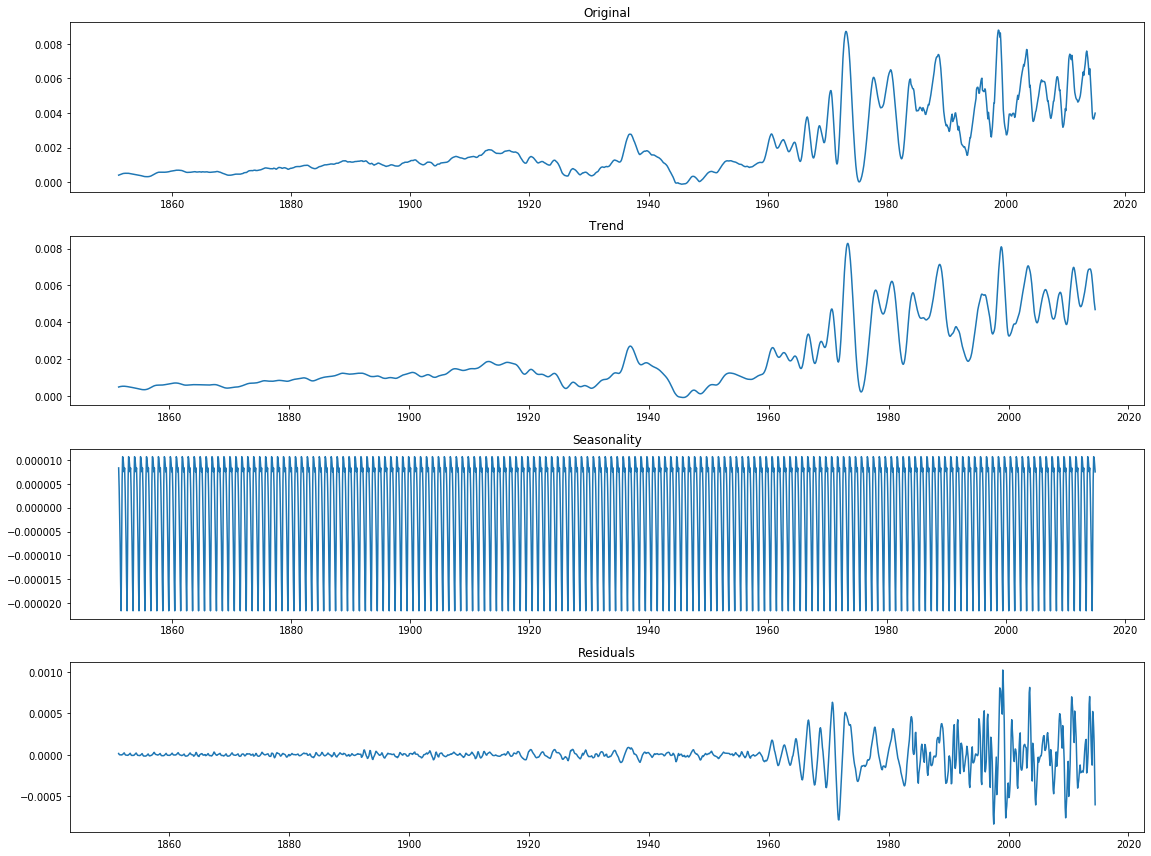

In [518]:
log_co2_diff12 = log_co2.diff(12).dropna()
trend, seasonal, residual = extract_seasonal_decomp_features(
    log_co2_diff12, freq=12, model='additive')
plot_decomposition(log_co2_diff12, trend, seasonal, residual.dropna())

And the AutoCorrelation Function corresponding this series:

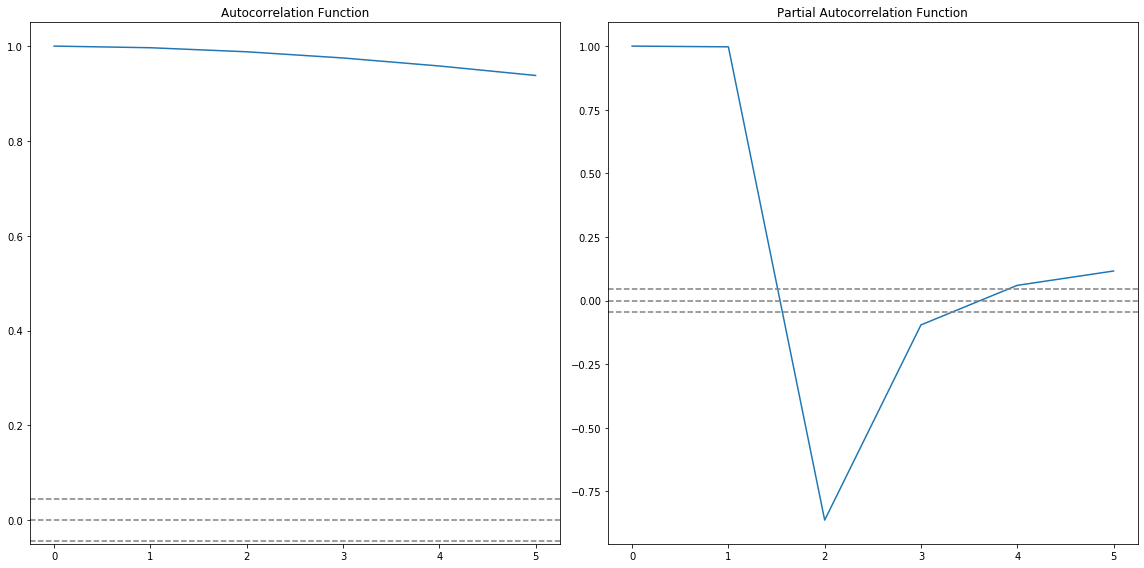

In [519]:
plot_acf_pacf(log_co2_diff12)

As noticed, the ACF decays very slowly, which reinforces that the CO2 time series in strongly auto-correlated, as well as strongly non-stationary.

Regarding the residuals, after seasonal differencing:

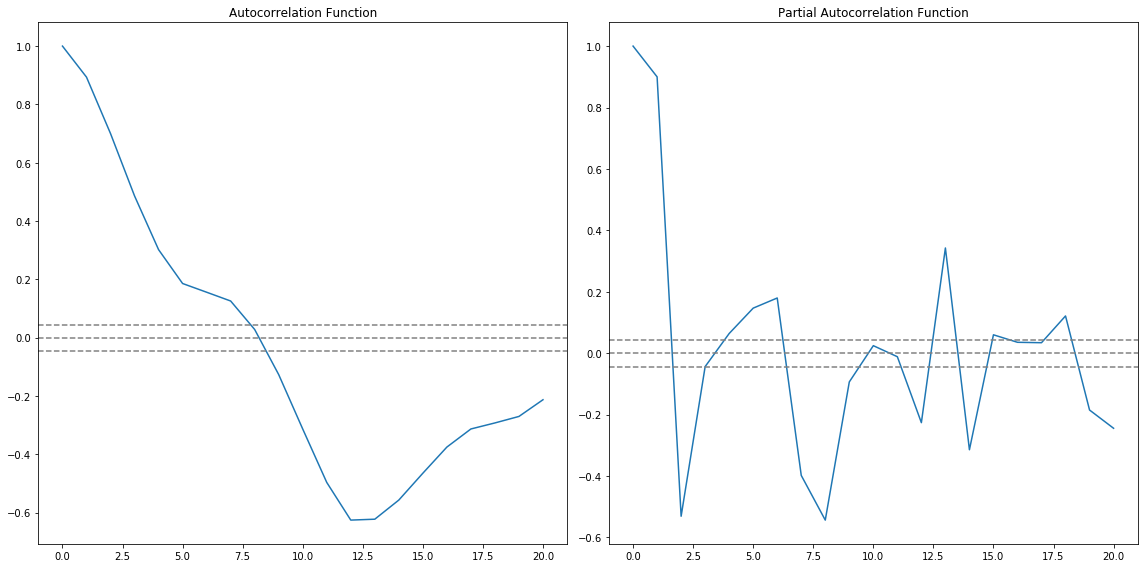

In [520]:
plot_acf_pacf(residual.dropna(), nlags=20)

As observed above, the CO2 mole concentration is a strongly non-stationary timeseries. In particular:
- There's a clear upward trend
- There's a strong seasonal component
- The variance of the residuals seems to be time dependent

In particular, after seasonal differencing of period 12, the data seems to be left only with trend, although it still displays a non-constant variance residual.

At tis point, an Augmented Dick-Fuller is not adequate nor it would add useful information, so it'll be skipped.

## 4.3. Conclusion to Task \#1:

The Land Average Temperature time series
- is non-stationary
- Augmented Dick-Fuller's p-value = 0.4871
- has a upwards trend
- has a high seasonality
- has seemingly normally-distributed residuals
- has a small degree of auto-correlation

The CO2 mole concentration:
- is highly non-stationary
- has a very step upwards trend
- has a high seasonality
- has clearly time dependent residuals
- has a very high auto-correlation

# 5. Task \#2: Correlation vs Causation



Regarding prediction, a variable X may be useful for forecasting a variable Y, but that does not mean X is causing Y$^{[1]}$. In fact it may be that: (1) Y is causing X, or (2) that the relationship between them is more complicated than simple causality.

Good examples are given in [Forecasting: Principles and Practice](https://otexts.com/fpp2/causality.html) online book. In scenario (1), it is possible to model the number of drownings at a beach resort each month with the number of ice-creams sold in the same period. But ice-creams are not causing drownings. People tend to eat more ice-creams on hot days when they are also more likely to go swimming. So the two variables (ice-cream sales and drownings) are correlated, but one is not causing the other. They are both possibly caused by a third variable (temperature). 

In (2), it is possible to forecast if it will rain in the afternoon by observing the number of cyclists on the road in the morning. When there are fewer cyclists than usual, it is more likely to rain later in the day. The model can give reasonable forecasts, not because cyclists prevent rain, but because people are more likely to cycle when the published weather forecast is for a dry day. In this case, there is a causal relationship, but in the opposite direction to our forecasting model. The number of cyclists falls because there is rain forecast. That is, x (rainfall) is affecting y (cyclists).

A common approach in Time Series analysis is to use the Granger causality test. But this approach is not to be used without caution and many argue that Granger causality can't be used as "true" causality.

Hence, especially on a global scale data such as the one in this report, even though it may be that there's a strong correlation between CO2 levels and Average Temperature, and that a Granger causality test yields positive causality, as stated above the problem is probably more complex, and involves many more factors that should be taken into account. Therefore, a more complete causality test would be performed involve a larger number of variables on a global scale, testing for confounding factor etc.

Regarding correlation, in order to compare both time series, we reindex the series to allign datetime indexes.

In [523]:
co2_reindexed = co2.copy()['1850':].reset_index()
co2_reindexed['datetime'] = co2_reindexed['datetime'].apply(lambda x: x.replace(day=1))
co2_reindexed = co2_reindexed.set_index('datetime').GlobalCO2
print(co2_reindexed.head())
print(co2_reindexed.tail())

datetime
1850-01-01    284.944656
1850-02-01    285.333792
1850-03-01    285.682825
1850-04-01    285.931179
1850-05-01    285.885928
Name: GlobalCO2, dtype: float64
datetime
2014-08-01    394.573461
2014-09-01    395.026810
2014-10-01    396.668760
2014-11-01    398.189074
2014-12-01    399.179692
Name: GlobalCO2, dtype: float64


In [524]:
landocean_temp_reindexed = landocean_temp['1850':'2014']
print(landocean_temp_reindexed.head())
print(landocean_temp_reindexed.tail())

dt
1850-01-01    12.833
1850-02-01    13.588
1850-03-01    14.043
1850-04-01    14.667
1850-05-01    15.507
Name: LandAndOceanAverageTemperature, dtype: float64
dt
2014-08-01    17.607
2014-09-01    16.975
2014-10-01    16.029
2014-11-01    14.899
2014-12-01    14.410
Name: LandAndOceanAverageTemperature, dtype: float64


From the time series plots displayed in each section, we can already see that both display an increasing trend, but that of the CO2 is much steeper. Exploring the correlation itself.

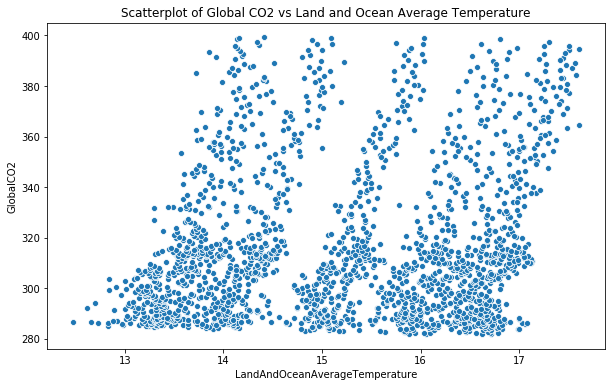

In [525]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=landocean_temp_reindexed, y=co2_reindexed)
plt.title('Scatterplot of Global CO2 vs Land and Ocean Average Temperature')
plt.show()

In [527]:
from sklearn.preprocessing import StandardScaler

From the scatterplot, no obvious correlation emerges. It may be that there are "groups" of Temperature and that, within these groups, an increased level of CO2 is associated with a higher Temperature, but this nis not made clear by the plot.

When the Pearson correlation is used to test for linear correlation, results are not particularly high either.

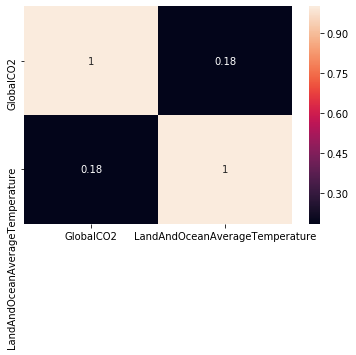

In [526]:
sns.heatmap(pd.concat([co2_reindexed, landocean_temp_reindexed], axis=1).corr(),
            annot=True)
plt.show()

As observed above, the linear correlation between both series is not obvious, although it may be that this correlation follows a non-linear trend.

# 6. Task \#3: Univariate Time Series Prediction

Exponential smoothing and ARIMA models are the two most widely used approaches to time series forecasting, and provide complementary approaches to the problem. While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.

To forecast a decomposed time series, we forecast the seasonal component, $S_t$, and the seasonally adjusted component $A_t$, separately. It is usually assumed that the seasonal component is unchanging, or changing extremely slowly, so it is forecast by simply taking the last year of the estimated component. In other words, a seasonal naïve method is used for the seasonal component.


Residuals are useful in checking whether a model has adequately captured the information in the data$^{[1]}$. For a forecasting method to be good, the residuals should have some properties:
1. The residuals should be uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals should have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.
3. The residuals have constant variance.
4. The residuals are normally distributed.

When building models, it's useful to have a baseline, i.e., a starting point in terms of prediction. In time series datathe naive or persistent approach is very common: the nest step in the series is forecast as being equal to the step just before it.

# 6.1. Land and Ocean Temperature

Taking what was learned by seasonal decomposition of the Land and Ocean Average Temperature series, it seems that accounting for trend and seasonality took into consideration all the information needed, as the residuals approximatelly displayed seemingly all of the 4 features for a good model.

Therefore, the [Holt-Winter's model](https://otexts.com/fpp2/holt-winters.html) would be an adequate first approach, as it models both trend and seasonality components, it's fairly easy to implement and could result in very sensible forecasts.

The Mean Squared Error, Mean Absolute Percent Error and Residuals diagnostics will be used to evaluate each model.

**Split into training and test sets**

In [216]:
train_temp, test_temp = landocean_temp_reindexed[:'2010'], landocean_temp_reindexed['2011':]
print(train_temp.tail())
print()
print(test_temp.head())

dt
2010-08-01    17.412
2010-09-01    16.761
2010-10-01    15.939
2010-11-01    14.995
2010-12-01    14.117
Name: LandAndOceanAverageTemperature, dtype: float64

dt
2011-01-01    13.928
2011-02-01    14.193
2011-03-01    14.880
2011-04-01    15.832
2011-05-01    16.523
Name: LandAndOceanAverageTemperature, dtype: float64


**The Naive approach**

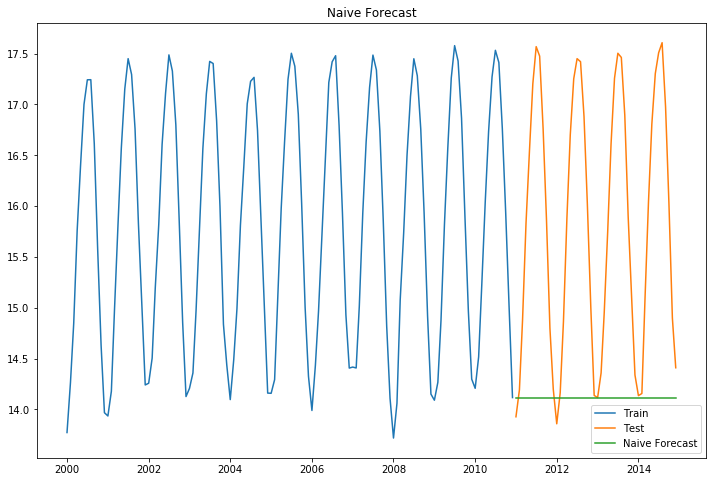

In [230]:
# predicted_values as array with all values equal to last value in Time Series
predicted_values = np.full(shape=test_temp.shape,
                           fill_value=train_temp[len(train_temp)-1])
naive_predicted_temp = pd.Series(predicted_values, index=test_temp.index)

# plot figure
plt.figure(figsize=(12,8))
plt.plot(train_temp['2000':], label='Train')
plt.plot(test_temp, label='Test')
plt.plot(naive_predicted_temp, label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

Naive Approach
RMSE: 2.1369760810157263
MAPE: 10.398738401046987


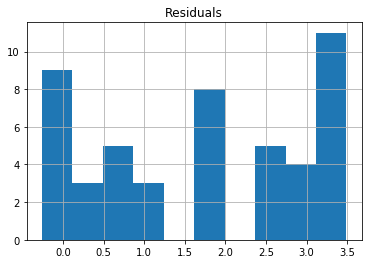

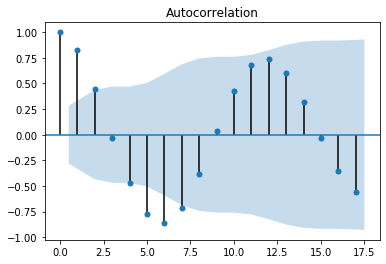

In [231]:
print_diagnostics(test_temp, naive_predicted_temp, 'Naive Approach')

**The Holt-Winter's model**

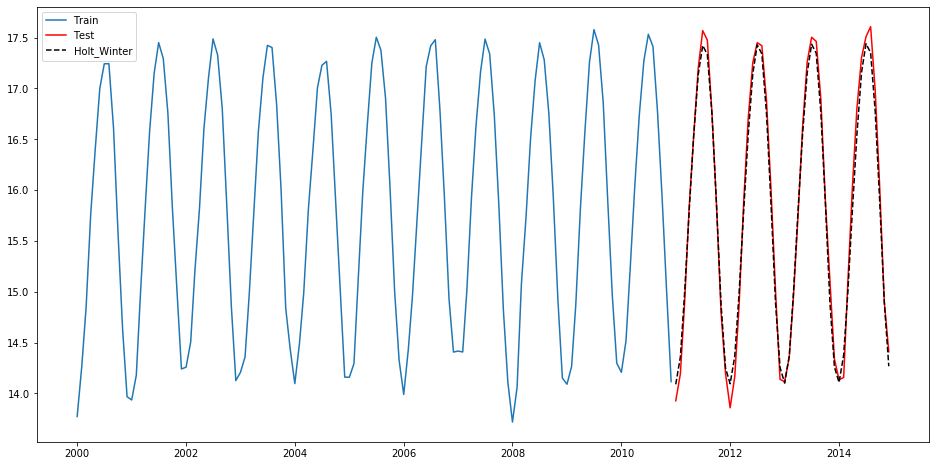

In [232]:
hw = ExponentialSmoothing(np.asarray(train_temp), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_predicted_temp = pd.Series(hw.forecast(len(test_temp)), index=test_temp.index)
plt.figure(figsize=(16,8))
plt.plot(train_temp['2000':], label='Train')
plt.plot(test_temp, label='Test', color='r')
plt.plot(hw_predicted_temp, 'k--', label='Holt_Winter')
plt.legend(loc='best')
plt.show()

Holt-Winter's Method
RMSE: 0.12957344584974123
MAPE: 0.6882047181540555


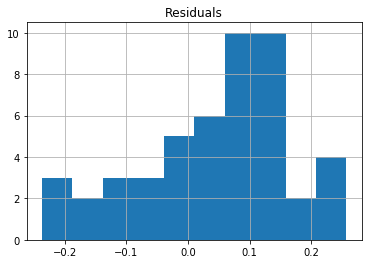

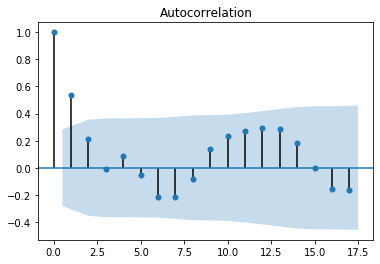

In [233]:
print_diagnostics(test_temp, hw_predicted_temp, 'Holt-Winter\'s Method')

**Comments**

The numeric results for RMSE and MAPE are better than for the Naive approach, which is to be expected. The Residuals, however, display signs of auto-correlation, as the value of ACF function for lag 1 is close to 0.6. As commented previously, the residuals left after seasonal decomposition of the Temperature Series are not completely random. In particular, the Temperature series has a greater variance at the beginning of the, and lower at the end of the series. This behavior should be taken into account as well. One possible approach would be to take a order 1 difference of the series, which could probably transform it into a stationary one. This procedure won't be presented here. 

In conclusion, Holt-Winter's method is a sensible, easy to implement first approach, but further investigation and model development could imporve the performance of the model.

# 6.2. CO2 Time Series

The naive seasonal decomposition of the CO2 series displayed trend and seasonality components, but inspection of the residuals also showed that there's more. Additionally, the ACF plot display a slowly decaying behavior, whereas the PACF plot seem to descrease rapidly after lag 1.

To account for the AutoCorrelation, trend and seasonal components, a Seasonal ARIMA will be used. The seasonal period is 12 months, and the PCAF plot suggest a *p* parameter for the Auto Regressive component of 1. Differencing will be attempted with by trial and error.

The Mean Squared Error, Mean Absolute Percent Error and Residuals diagnostics will be used to evaluate the models.

**Split into training and test sets**

In [567]:
co2 = np.log(co2_reindexed).dropna()
# split into training and test sets
train_co2, test_co2 = co2[:'2010'], co2['2011':]
print(train_co2.tail())
print()
print(test_co2.head())

datetime
2010-08-01    5.956230
2010-09-01    5.957510
2010-10-01    5.961733
2010-11-01    5.965593
2010-12-01    5.968080
Name: GlobalCO2, dtype: float64

datetime
2011-01-01    5.970114
2011-02-01    5.971219
2011-03-01    5.971960
2011-04-01    5.972314
2011-05-01    5.971326
Name: GlobalCO2, dtype: float64


**The Naive approach**

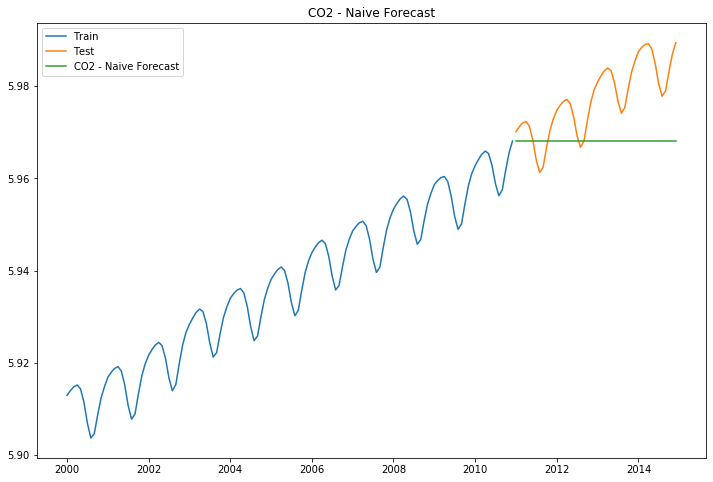

In [568]:
# predicted_values as array with all values equal to last value in Time Series
predicted_co2_values = np.full(shape=test_co2.shape,
                               fill_value=train_co2[len(train_co2)-1])
naive_predicted_co2 = pd.Series(predicted_co2_values, index=test_co2.index)

# plot figure
plot_predictions(train_co2['2000':], test_co2, naive_predicted_co2, 'CO2 - Naive Forecast')

CO2 - Naive Forecast
RMSE: 0.011696603026350845
MAPE: 0.16438667275640473


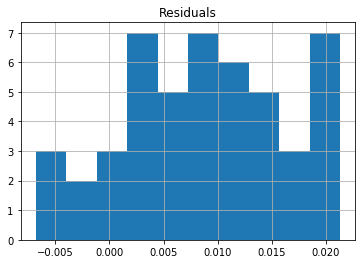

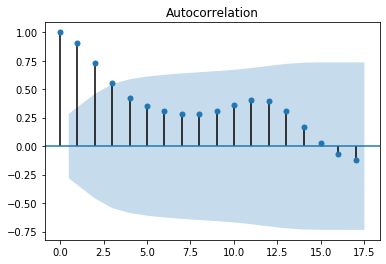

In [569]:
print_diagnostics(test_co2, naive_predicted_co2, 'CO2 - Naive Forecast')

**SARIMA model**

In [546]:
def plot_predictions(y_train, y_test, y_predicted, title, figsize=(12,8)):
    
    plt.figure(figsize=figsize)
    plt.plot(y_train, label='Train')
    plt.plot(y_test, label='Test')
    plt.plot(y_predicted, label=title)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

    return None

In [465]:
find_best_sarima(train_co2, 'aic', seasonal_period=12)

              0             1          2              3
1  12241.336914  12246.903225  (0, 0, 0)  (0, 0, 0, 12)
2   9638.319151   9649.451773  (0, 0, 0)  (0, 0, 1, 12)
3 -17293.691146 -17288.131065  (0, 0, 0)  (0, 1, 0, 12)
4 -18719.233285 -18708.113124  (0, 0, 0)  (0, 1, 1, 12)
5 -13214.191650 -13203.059028  (0, 0, 0)  (1, 0, 0, 12)
6 -15254.944590 -15238.245657  (0, 0, 0)  (1, 0, 1, 12)
7 -20212.903287 -20201.783126  (0, 0, 0)  (1, 1, 0, 12)
8 -20211.146896 -20194.466654  (0, 0, 0)  (1, 1, 1, 12)


KeyError: "None of [Index(['aic'], dtype='object')] are in the [columns]"

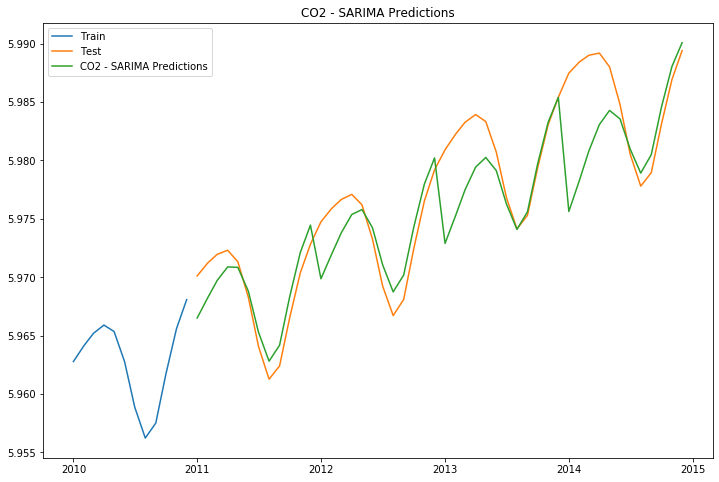

SARIMA Predictions
RMSE: 0.0037241838491026973
MAPE: 0.043554033328879145


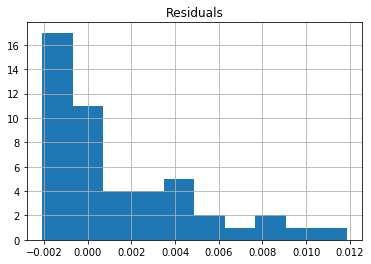

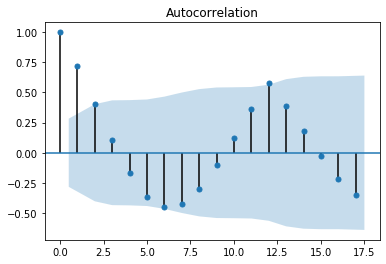

In [573]:
sarima = sm.tsa.statespace.SARIMAX(train_co2, order=(1,0,0), seasonal_order=(1,1,0,12)).fit()
sarima_predicted_co2 = sarima.predict(start="2011-01-01", end="2014-12-01", dynamic=True)
plot_predictions(train_co2['2010':], test_co2, sarima_predicted_co2, 'CO2 - SARIMA Predictions')
print_diagnostics(test_co2, sarima_predicted_co2, print_message='SARIMA Predictions')

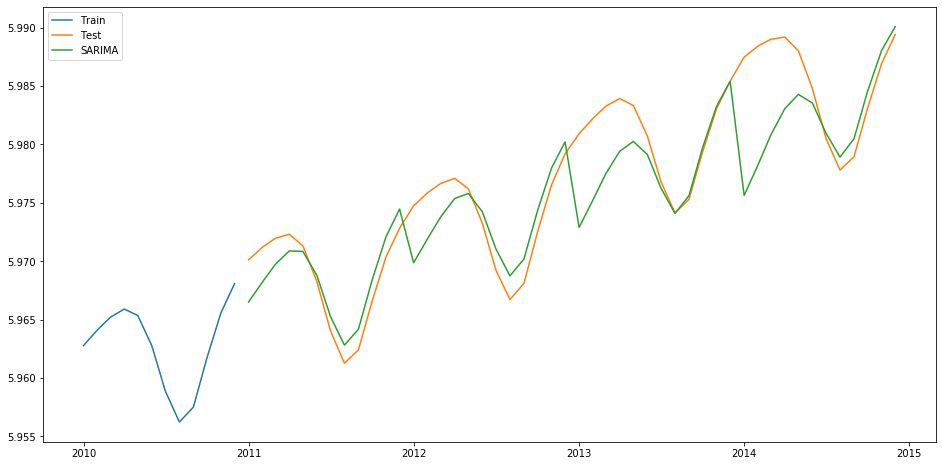

In [457]:
plt.figure(figsize=(16,8))
plt.plot(, label='Train')
plt.plot(, label='Test')
plt.plot(, label='SARIMA')
plt.legend(loc='best')
plt.show()

SARIMA Predictions
RMSE: 0.003724180692927518
MAPE: 0.043554161413900574


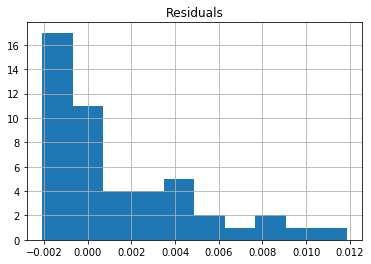

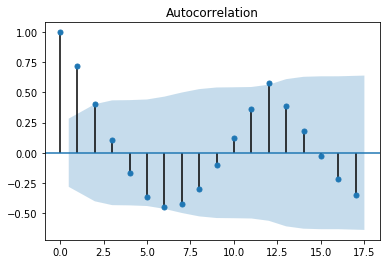

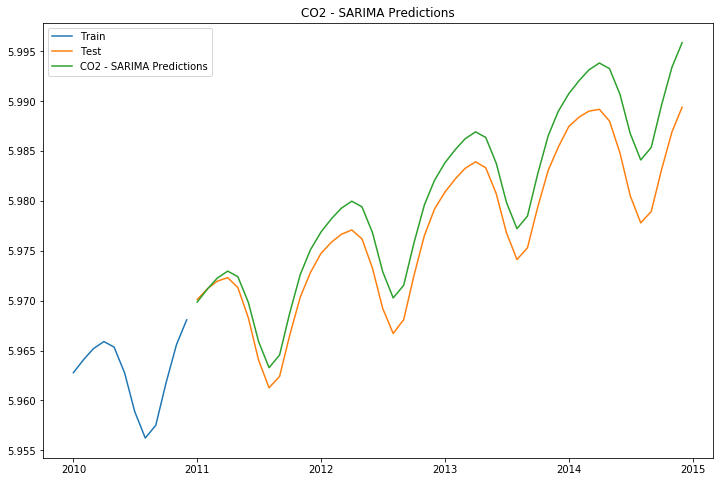

SARIMA Predictions
RMSE: 0.003641580649036571
MAPE: 0.0544644971657967


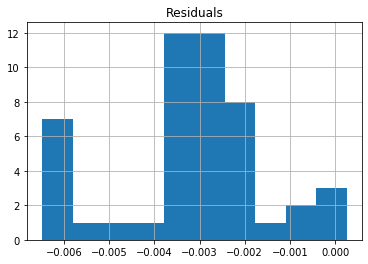

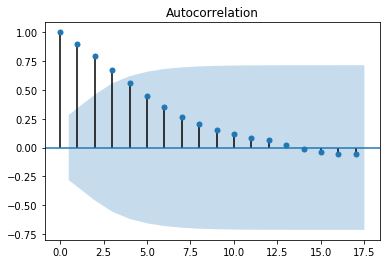

In [556]:
sarima = sm.tsa.statespace.SARIMAX(train_co2, order=(1, 0, 0), seasonal_order=(1,0,0,12)).fit()
sarima_predicted_co2 = sarima.predict(start="2011-01-01", end="2014-12-01")
plot_predictions(train_co2['2010':], test_co2, sarima_predicted_co2, 'CO2 - SARIMA Predictions')
print_diagnostics(test_co2, sarima_predicted_co2, print_message='SARIMA Predictions')

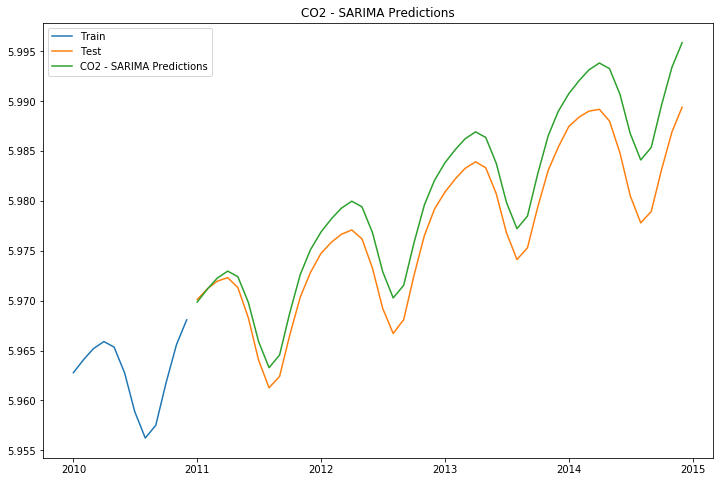

SARIMA Predictions
RMSE: 0.003641580649036571
MAPE: 0.0544644971657967


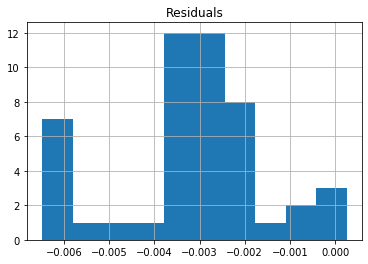

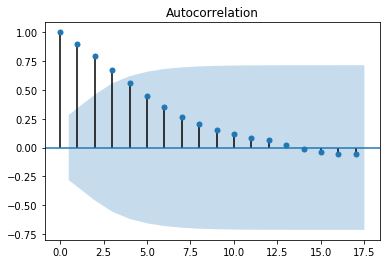

In [556]:
sarima = sm.tsa.statespace.SARIMAX(train_co2, order=(1, 0, 0), seasonal_order=(1,0,0,12)).fit()
sarima_predicted_co2 = sarima.predict(start="2011-01-01", end="2014-12-01")
plot_predictions(train_co2['2010':], test_co2, sarima_predicted_co2, 'CO2 - SARIMA Predictions')
print_diagnostics(test_co2, sarima_predicted_co2, print_message='SARIMA Predictions')

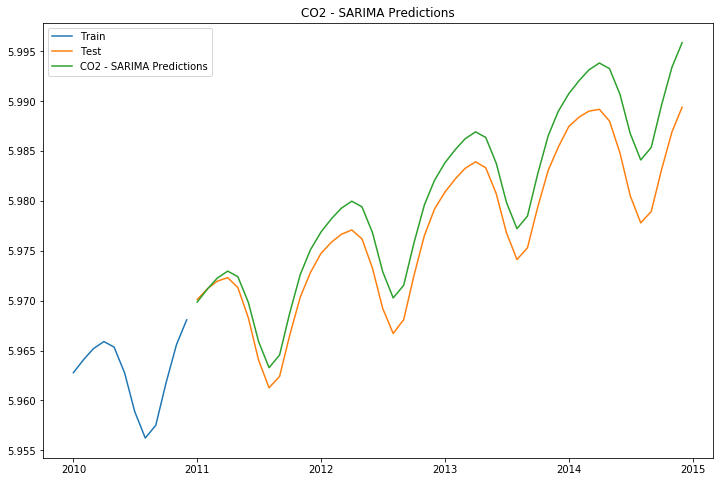

SARIMA Predictions
RMSE: 0.003641580649036571
MAPE: 0.0544644971657967


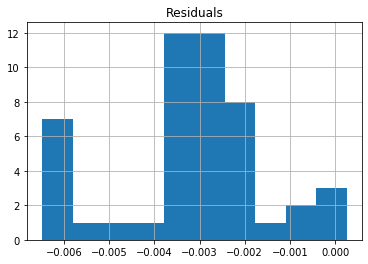

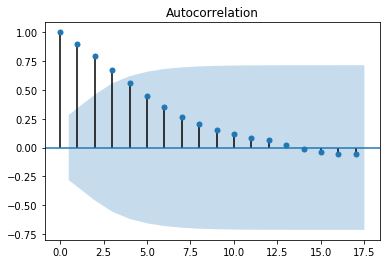

In [556]:
sarima = sm.tsa.statespace.SARIMAX(train_co2, order=(1, 0, 0), seasonal_order=(1,0,0,12)).fit()
sarima_predicted_co2 = sarima.predict(start="2011-01-01", end="2014-12-01")
plot_predictions(train_co2['2010':], test_co2, sarima_predicted_co2, 'CO2 - SARIMA Predictions')
print_diagnostics(test_co2, sarima_predicted_co2, print_message='SARIMA Predictions')

As observed, 

# 7. Task \#4: Multivariate Prediction 

# 8. References

\[1\] Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 2019-01-12.

\[2\] Brownlee, J. (2017) Seasonal Persistence Forecasting With Python, https://machinelearningmastery.com/seasonal-persistence-forecasting-python/. Acsessed on 2019-01-12.

\[3\] Jain, A. (2016) A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python and R), https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/. Acsessed on 2019-01-12.
